In [1]:
from ML_utils import ML_utils
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt

In [2]:
dir_path = r'D:\Backup\ml_data\GitHub\ML_Sentiment_analysis\Dataset'
x = np.load(os.path.join(dir_path,'vec_x_neg2000_pos2000.npy'))
y = np.load(os.path.join(dir_path,'vec_y_neg2000_pos2000.npy'))

In [3]:
x_train = np.concatenate((x[:1200],x[2000:3200]))
y_train = np.concatenate((y[:1200],y[2000:3200]))
x_test = np.concatenate((x[1200:2000],x[3200:4000]))
y_test = np.concatenate((y[1200:2000],y[3200:4000]))
del x,y

In [4]:
class Dataset(data.Dataset):
    def __init__(self,x,y,transform=None,target_transform=None):
#         self.transform = transform
#         self.target_transform = target_transform
        self.data_X = x
        self.data_Y = y
        
    def __getitem__(self, index):
        X = self.data_X[index]
        Y = self.data_Y[index]
#         if self.transform != None:
#             X = self.transform(X)
#         if self.target_transform != None:
#             Y = self.transform(Y)
        return X, Y
                
    def __len__(self):
        return len(self.data_X)

In [5]:
batch_size = 400
train_data = Dataset(x_train,y_train)
trainloader = torch.utils.data.DataLoader(train_data, batch_size = batch_size ,shuffle=False, num_workers=0)
test_data = Dataset(x_train,y_train)
testloader = torch.utils.data.DataLoader(test_data, batch_size = batch_size ,shuffle=False, num_workers=0)
del train_data,test_data,x_train,y_train,x_test,y_test

In [6]:
seq_len = 60
input_size = 300
rnn_hidden_size = 100
rnn_num_layers = 2
output_size = 2
hidden_size = seq_len*rnn_hidden_size

class LSTM_model(nn.Module):
    def __init__(self, ):
        super(LSTM_model, self).__init__()
        self.lstm0 = nn.LSTM(
            input_size=input_size,
            hidden_size=rnn_hidden_size,
            num_layers=rnn_num_layers,
            batch_first=True)
        self.linear = nn.Linear(hidden_size, hidden_size)
        self.linear0 = nn.Linear(hidden_size, hidden_size)
        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
        for name,p in self.named_parameters():
            if (name.find('rnn') == 0):
                nn.init.normal_(p, mean=0.0, std=0.001)
            elif (name.find('linear') == 0) and (name.find('weight') == 0):        
                nn.init.xavier_normal_(p)
    def forward(self, x, h0,c0):
        # [b, seq, h]
        out, (h0_,c0_) = self.lstm0(x, (h0,c0))
        out = out.reshape(-1,hidden_size)
        out = self.linear(out)
        out = nn.functional.relu(out)
        out = self.linear0(out)
        out = nn.functional.relu(out)
        out = self.linear1(out)
        out = self.linear2(out)
        return out, (h0_,c0_)

In [7]:
#[rnn_layer,b,hidden_size]
h0 = torch.zeros(rnn_num_layers, batch_size, rnn_hidden_size,device='cuda:0')
c0 =  torch.zeros(rnn_num_layers, batch_size, rnn_hidden_size,device='cuda:0')
model = LSTM_model()
model.cuda('cuda:0')

LSTM_model(
  (lstm0): LSTM(300, 100, num_layers=2, batch_first=True)
  (linear): Linear(in_features=6000, out_features=6000, bias=True)
  (linear0): Linear(in_features=6000, out_features=6000, bias=True)
  (linear1): Linear(in_features=6000, out_features=6000, bias=True)
  (linear2): Linear(in_features=6000, out_features=2, bias=True)
)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

In [9]:
model.train()
lr = 0.00001
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr)

In [10]:
def train():
    global h0
    global c0
    trainloss_list = []
    testloss_list = []
    for epoch in range(100):
        data_iter = iter(trainloader)
        for batch in data_iter:
            x = batch[0].to(device=device,dtype=dtype)
            y = batch[1].to(device=device,dtype=dtype)
            output,(h0_,c0_) = model(x, h0, c0)
            h0 = h0_.detach()
            c0 = c0_.detach()
            loss = criterion(output, y)
            model.zero_grad()
            loss.backward()
    #         for p in model.parameters():
    #             torch.nn.utils.clip_grad_norm_(p, 10)
            optimizer.step()
    #     print("Iteration: {} loss {}".format(epoch+1, loss.item()))
    #     loss_list.append(loss.item())
        if (epoch+1) % 10 == 0:
            print("Iteration: {} Train.loss {}".format(epoch+1, loss.detach()))
            trainloss_list.append(loss.item())
        data_iter = iter(testloader)
        for batch in data_iter:
            x = batch[0].to(device=device,dtype=dtype)
            y = batch[1].to(device=device,dtype=dtype)
            output,(h0_,c0_) = model(x, h0, c0)
            h0 = h0_.detach()
            c0 = c0_.detach()
            loss = criterion(output, y)
            model.zero_grad()
            loss.backward()
    #         for p in model.parameters():
    #             torch.nn.utils.clip_grad_norm_(p, 10)
            optimizer.step()
    #     print("Iteration: {} loss {}".format(epoch+1, loss.item()))
    #     loss_list.append(loss.item())
        if (epoch+1) % 10 == 0:
            print("Iteration: {} Test.loss {}".format(epoch+1, loss.detach()))
            testloss_list.append(loss.item())
    return trainloss_list,testloss_list

Iteration: 10 Train.loss 0.0003532852861098945
Iteration: 10 Test.loss 0.0003260502708144486
Iteration: 20 Train.loss 0.00010574048064881936
Iteration: 20 Test.loss 9.851196955423802e-05
Iteration: 30 Train.loss 5.497113670571707e-05
Iteration: 30 Test.loss 5.48661409993656e-05
Iteration: 40 Train.loss 4.651402196031995e-05
Iteration: 40 Test.loss 4.4520995288621634e-05
Iteration: 50 Train.loss 0.00014236793504096568
Iteration: 50 Test.loss 9.199175838148221e-05
Iteration: 60 Train.loss 4.87589422846213e-05
Iteration: 60 Test.loss 5.926219455432147e-05
Iteration: 70 Train.loss 2.703171776374802e-05
Iteration: 70 Test.loss 3.1474050047108904e-05
Iteration: 80 Train.loss 2.2994914615992457e-05
Iteration: 80 Test.loss 2.492782732588239e-05
Iteration: 90 Train.loss 0.0001885712699731812
Iteration: 90 Test.loss 0.0001400523615302518
Iteration: 100 Train.loss 0.0002716230519581586
Iteration: 100 Test.loss 0.00012039399007335305


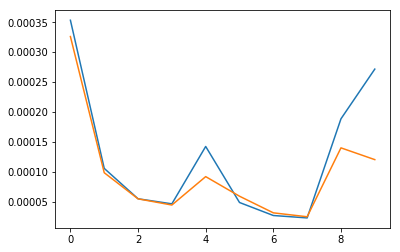

In [12]:
trainloss_list,testloss_list = train()
plt.plot(trainloss_list)
plt.plot(testloss_list)
plt.show()

In [13]:
import re
from gensim.models import word2vec
import logging
import jieba

class predict_config():
    def __init__(self,h0,c0,word_vec_path):
        self.word_vec_model = word2vec.Word2Vec.load(word_vec_path)
        self.pre_h0 = h0.clone().detach()
        self.pre_c0 = c0.clone().detach()
        self.padding = np.zeros((1,300),dtype=np.float32)

def jieba_string(chat):
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    logging.disable(50)
    output = []
    # jieba custom setting.
    jieba.set_dictionary('jieba_dict/dict.txt.big')
    # load stopwords set
    #將停用詞每row分別加進集合
    stopword_set = set()
    #設置停用詞讀取路徑
    with open('jieba_dict/robot_stop_1.txt','r', encoding='utf-8') as stopwords:
        for stopword in stopwords:
            stopword_set.add(stopword.strip('\n'))   #移除頭尾換行 strip('\n')
    chat = chat.strip('\n')
    words = jieba.cut(chat, cut_all=False,HMM=True)    #進行斷詞
    for word in words:
        #依每個詞判斷是否為停用詞(不是就寫入)
        if word not in stopword_set:
            output.append(word)
    return output

def chat(chat,config):
    jieba_list = jieba_string(chat)
    if len(jieba_list) > seq_len:
        jieba_list = jieba_list[:seq_len]
    if len(jieba_list) < seq_len:
        for num in range(seq_len-len(jieba_list)):
            jieba_list.append(0)
    vec_array = np.zeros((1,300),dtype=np.float32)
    for word in jieba_list:
        if word == 0:
            vec = config.padding
            vec_array = np.concatenate((vec_array,vec),axis=0)
        else:
            try:
                vec = np.array(config.word_vec_model.wv.get_vector(word),np.float32).reshape(1,300)
                vec_array = np.concatenate((vec_array,vec),axis=0)
            except KeyError:
                vec = config.padding
                vec_array = np.concatenate((vec_array,vec),axis=0)
    X = vec_array[1:].reshape(1,-1,300)
    X = torch.tensor(X)
    return X

def input_to_predict(chat_input,config):
    x = chat(chat_input,config)
    x = x.to(device=device,dtype=dtype)
    output,(h0_,c0_)= model(x, config.pre_h0[:,:len(x),:].clone(), config.pre_c0[:,:len(x),:].clone())
#     config.pre_h0 = h0_.detach()
#     config.pre_c0 = c0_.detach()
    predict = torch.argmax(output)
    print(chat_input)
    if predict == 0:
        print('Bad!!')
    if predict == 1:
        print('Good!!')
    return output

In [14]:
word_vec_path = r'D:\Backup\ml_data\GitHub\ML_Sentiment_analysis\word2vec_model\word2vec_model'
config = predict_config(h0,c0,word_vec_path)

In [15]:
print('test:')
input_to_predict('很親切',config)
input_to_predict('非常不錯',config)
input_to_predict('好棒!',config)
input_to_predict('服務很糟糕...，但整體來說還不錯。',config)
input_to_predict('房間還不錯，但服務很差。',config)
input_to_predict('東西很便宜，店員很親切。',config)
input_to_predict('出貨慢，態度差。',config)
input_to_predict('出貨慢',config)

test:
很親切
Good!!
非常不錯
Good!!
好棒!
Good!!
服務很糟糕...，但整體來說還不錯。
Bad!!
房間還不錯，但服務很差。
Bad!!
東西很便宜，店員很親切。
Good!!
出貨慢，態度差。
Bad!!
出貨慢
Bad!!


tensor([[0.8902, 0.0970]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
while True:
    input_chat = input('輸入評論：')
    input_to_predict(input_chat,config)

輸入評論：爛
爛
Bad!!
輸入評論：不錯
不錯
Good!!
輸入評論：好棒棒
好棒棒
Good!!
輸入評論：好棒
好棒
Good!!
輸入評論：水果好ㄘ
水果好ㄘ
Good!!
輸入評論：品質還可以，服務也一般，但出貨快。
品質還可以，服務也一般，但出貨快。
Good!!
輸入評論：這遊戲好玩
這遊戲好玩
Good!!
輸入評論：以後不會再買
以後不會再買
Bad!!
輸入評論：以後一定再買
以後一定再買
Good!!
